# System Identification

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions

In [5]:
# generate data
n = 100

real_x = Vector{Float64}(undef, n)
real_w = Vector{Float64}(undef, n)
real_y = Vector{Float64}(undef, n)

real_x_τ = 0.1
real_w_τ = 0.1

x_i_min = 0.0
w_i_min = 1.0

for i in 1:n
    real_x[i] = rand(Normal(x_i_min, sqrt(1.0 / real_x_τ)))
    real_w[i] = rand(Normal(w_i_min, sqrt(1.0 / real_w_τ)))
    real_y[i] = rand(Normal(real_x[i] + real_w[i], 1.0))
    
    x_i_min = real_x[i]
    w_i_min = real_w[i]
end

In [49]:
@model function identification_problem(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w)
    
    x0 ~ NormalMeanPrecision(m_x_0, τ_x_0)
    
    τ_x ~ Gamma(a_x, b_x)
    
    w0 ~ NormalMeanPrecision(m_w_0, τ_w_0)
    
    τ_w ~ Gamma(a_w, b_w)
    
    x = randomvar(n)
    w = randomvar(n)
    x_w = randomvar(n)
    y = datavar(Float64, n)
    
    
    x_i_min = x0
    w_i_min = w0
    
    P = constvar(1.0)
    
    for i in 1:n
        x[i] ~ NormalMeanPrecision(x_i_min, τ_x)
        w[i] ~ NormalMeanPrecision(w_i_min, τ_w)
        x_w[i] ~ x[i] + w[i]
        y[i] ~ NormalMeanPrecision(x_w[i], P)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
    return x, w, y, τ_x, τ_w
end

In [63]:
constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, x_w) = q(x, x0, w, w0, x_w)q(τ_w)q(τ_x)
end;

In [91]:
m_x_0, τ_x_0 = 0.0, 100.0
m_w_0, τ_w_0 = 1.0, 100.0

a_x, b_x = 1.0, 1.0
a_w, b_w = 1.0, 1.0

imessages = (x = vague(NormalMeanPrecision), w = vague(NormalMeanPrecision))
imarginals = (τ_x = vague(GammaShapeRate), τ_w = vague(GammaShapeRate))

result = inference(model=Model(identification_problem, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w),
                  data=(y=real_y,), constraints=constraints, 
                  initmessages=imessages, initmarginals=imarginals, 
                  iterations=100, showprogress=true);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [92]:
τ_x_marginals, τ_w_marginals = result.posteriors[:τ_x], result.posteriors[:τ_w]

xmarginals, wmarginals = result.posteriors[:x], result.posteriors[:w];

In [93]:
mean.(τ_x_marginals)[end], mean.(τ_w_marginals)[end]

(0.11230986333029691, 0.11230986335990967)

In [94]:
using Plots

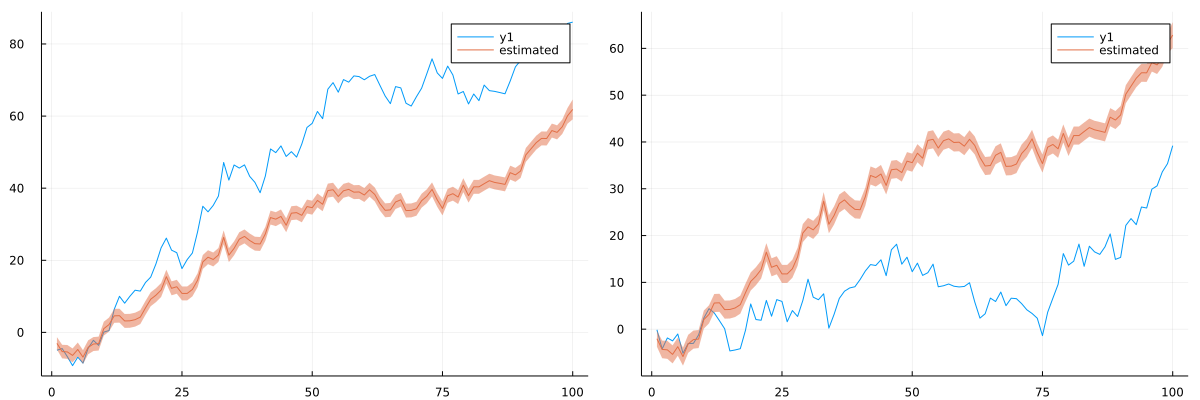

In [99]:
px1 = plot()
px2 = plot()

px1 = plot!(px1, real_x)
px1 = plot!(px1, mean.(xmarginals[end]), ribbon = std.(xmarginals[end]), label = "estimated")

px2 = plot!(px2, real_w)
px2 = plot!(px2, mean.(wmarginals[end]), ribbon = std.(wmarginals[end]), label = "estimated")

plot(px1, px2, size = (1200, 400))

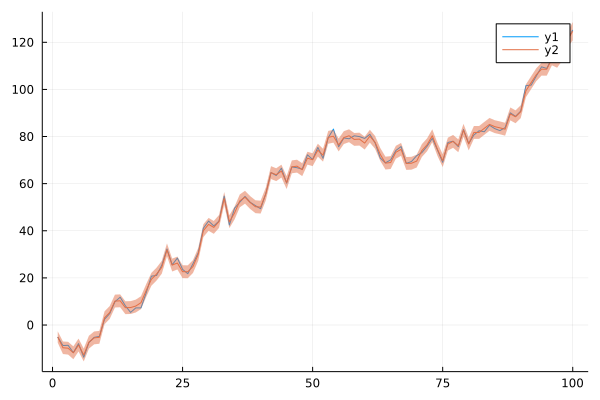

In [101]:
p = plot()

p = plot!(p, real_x .+ real_w)
p = plot!(p, mean.(xmarginals[end]) + mean.(wmarginals[end]), ribbon = (var.(xmarginals[end]) + var.(wmarginals[end])) .|> sqrt)